In [1]:
#setup imports and make ure the files we care about exist
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path
from pprint import pprint

#custom modules
import feature_extraction
import unsw_nb15_dataset
import networks

from importlib import reload #allow us to reload custom modules any time we like with modifications
reload(feature_extraction)
reload(unsw_nb15_dataset)
reload(networks)

<module 'networks' from '/home/jaywalker/MachineLearning/PacketGAN/networks.py'>

In [2]:
#set up the dataset(s)

#set some hyperparameters
sequence_length=25
batch_size=64 #always using size 1 because I can't seem to make the GRU work correctly with larger batches

#first, load the dataset
data_set = unsw_nb15_dataset.UNSW_NB15('UNSW_NB15_full_clean.csv',
                                       sequence_length=sequence_length, 
                                       transform=feature_extraction.build_feature_sequence_tensor)

#pick out the attack examples
data_set.use_only_category('DoS'); #in this case just look at DoS attack samples 

#get rid of this when you want to use the whole set
fraction_to_use = 0.05
data_set, _ = random_split(data_set, [round(len(data_set) * fraction_to_use), len(data_set) - round(len(data_set) * fraction_to_use)])

train_set_length = round(len(data_set) * 0.8)
test_set_length = len(data_set) - train_set_length
train_set, test_set = random_split(data_set, [train_set_length, test_set_length])

data_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=2)

data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Network input data shape: ", data_example.shape)
print("Number of training examples: ", len(data_loader.dataset))

/home/jaywalker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Network input data shape:  torch.Size([64, 25, 137])
Number of training examples:  2613


Number of input features:  137
Latent dimensions:  25


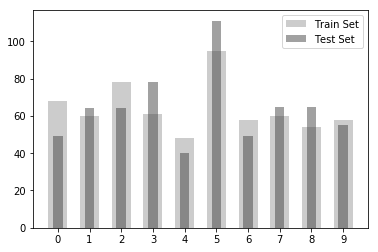

In [3]:
#train a KMeans classifier for cluster evaluation
import evaluation
reload(evaluation)

num_features = data_set[0].shape[1]
print("Number of input features: ", num_features)
latent_dimensions = 25
print("Latent dimensions: ", latent_dimensions)

latent_space_mapper = networks.GRUMapping(num_features, latent_dimensions, batch_size)

#convert the train_set and test_set to a lower dimensional space for clustering
train_set_latent = []
train_comparison_set, _ = random_split(train_set, [len(test_set), len(train_set) - len(test_set)])
train_comparison_set_dl = torch.utils.data.DataLoader(train_comparison_set, batch_size=batch_size, shuffle=True) #use a dataloader so the examples are batched
with torch.no_grad():
    for example in train_comparison_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network so we don't have to deal with too many technicalities...
            #maybe we could deal with that by changing the size of the hidden state of the network before inputting the data?
        train_set_latent.extend(latent_space_mapper(example).numpy()[0])
        
#print(train_set_latent)

test_set_latent = []
test_set_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
with torch.no_grad():
    for example in test_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network to keep things easy
        test_set_latent.extend(latent_space_mapper(example).numpy()[0])

#print("Latent test set length: ", len(test_set_latent))
#pprint(test_set_latent)
#print("Latent test set element size: ", test_set_latent[0].shape)
kmeans = evaluation.KMeansTorch(n_clusters=10)
kmeans.fit(train_set_latent)

#are the train set and test set from the same distribution?
train_counts, test_counts = evaluation.cluster_and_compare(kmeans, train_set_latent, test_set_latent, retrain=False)

In [4]:
#define the networks 
G = networks.Generator(sequence_length, data_example.shape[2], data_example.shape[2] * 2, 30, data_example.shape[2], batch_size, torch.sigmoid, noise_input=True)
D = networks.Discriminator(sequence_length, data_example.shape[2], data_example.shape[2] * 2, 1, batch_size, torch.sigmoid)

In [ ]:
#train GAN to replace masked packets
#by iterating over the dataset for some # of epochs

import train
reload(train)
reload(networks)

#Train the network!
num_epochs = 1
G, D, g_losses, df_losses, g_stats, df_stats = train.train_gan(G,D,data_loader,num_epochs)

#plot instantaneous losses
plt.plot(range(len(df_losses)), df_losses, 'r-', range(len(g_losses)), g_losses, 'g-')
plt.show()

#plot loss averages
plt.plot(range(len(df_stats.get_averages())), df_stats.get_averages(), 'r-', range(len(g_stats.get_averages())), g_stats.get_averages(), 'g-')
plt.show()

#cluster and compare. Are the fake examples even remotely matching the original distribution?
#first generate a set of masked sequences
gan_latent_test_set = []
with torch.no_grad():
    for example in test_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network to keep things easy
        generated_example = G(example)
        gan_latent_test_set.extend(latent_space_mapper(generated_example).numpy()[0])

#then compare the native GAN output
train_counts, test_counts = evaluation.cluster_and_compare(kmeans, train_set_latent, gan_latent_test_set, retrain=False)

Training: [------------------------------] 0.5%
Epoch:  1 / 1
D Real Error:  0.26645028591156006
D Fake Error:  0.25168389081954956
G Error:  1.5283095836639404
Remaining time: 1:27:19.159004


In [ ]:
#This is a test of the wasserstein critic/approximate wasserstein distance
import torch.utils.data
import evaluation
reload(evaluation)

for k in range(0, 1):
    real_set, generator_input, _ = random_split(test_set, [len(test_set) // 2, len(test_set) // 2, len(test_set) - 2*(len(test_set) // 2)]) #I'm assuming it's got at least 200 examples to spare
    real_list = []
    #assuming real_train_set and real_test_set are equal length
    for i in range(0, len(real_set)):
        real_list.append(feature_extraction.batchify([real_set[i]]))
        
    fake_set = []
    for i in range(0, len(generator_input)):
        #for this example I'll just use the raw generator output. We can mask later.
        #this way it's consistent with the histogram above.
        with torch.no_grad():
            fake_set.append(G(feature_extraction.batchify([generator_input[i]]))) #G ouput already has batch dimension
            
    #print(len(real_set))
    #print(real_list[0].shape)
    #print(fake_set[0].shape)
            
    w_hat, accuracy = evaluation.wasserstein_critic(real_list, fake_set)
    print("Wasserstein Distance: ", w_hat)
    print("Classification Accuracy: ", accuracy)


In [ ]:
def print_dict_compare(dict1, dict2):
    for k in dict1:
        if k not in dict2:
            return None
        
    for k in dict1:
        print(dict1[k], "\t\t", dict2[k])

def dict_list_compare(dict_list1, dict_list2):
    for l in range(0, len(dict_list1)):
        print_dict_compare(dict_list1[l], dict_list2[l])
    print("\n\n")

            
import random
data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Real data\tFake data")
real_data = feature_extraction.decode_feature_sequence_tensor(data_set, data_example[0])

#note here that "gen" is the trained generator returned from the training function above
generated_data = G(data_example).detach()
fake_data = feature_extraction.decode_feature_sequence_tensor(data_set, generated_data[0])

dict_list_compare(real_data, fake_data)

#print("From data set:")
#print(feature_extraction.decode_feature_sequence_tensor(data_set, data_set[0]))